# PRÁCTICA 4.1. REGULARIZACIÓN EN REDES NEURONALES

En los ejemplos presentados anteriormente hemos comprobado que en la validación el rendimiento de los modelos suele presentar un máximo tras unas pocas epochs y entonces comienza a degradarse, es decir, que los modelos comienzan a **sobreajustarse** a los datos de entrenamiento sin que haya dado tiempo a extraer patrones suficientemente útiles de ellos para poder ser aplicados sobre datos no vistos.

![](https://github.com/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/imgs/TestTraining.png?raw=1)

Como hemos comentado más veces, el sobreajuste es común a todos los problemas de Machine Learning (ML), y se hace más patente cuanta **menor cantidad de datos** tengamos para entrenar. Por ello, saber reconocerlo y dar pautas para mitigar sus efectos se convierten en tareas esenciales para obtener buenos resultados en la aplicación de técnicas de ML/DL.

El problema fundamental de ML (y, en general, de muchas otras técnicas de la IA) es la tensión existente entre **optimización** y **generalización**, donde la optimización se considera respecto al proceso de ajustar un modelo para conseguir el mejor rendimiento posible sobre los datos de entrenamiento (es donde se concentra la parte de _aprendizaje_ en el  Aprendizaje Automático), y la generalizacion es respecto a lo bien que el modelo entrenado se comporta sobre datos que no ha visto anteriormente. El objetivo, por supuesto, es conseguir una buena generalización, pero es precisamente la parte que no podemos controlar, ya que solo podemos ajustar el modelo en función los datos conocidos (de entrenamiento).

Cuando el entrenamiento empieza, la optimización y la generalización están correlacionadas (sobre todo, teniendo en cuenta que normalmente se comienza con un modelo cuya asignación de pesos es aleatoria): cuanto menor es el error sobre los datos de entrenamiento, menor es sobre los datos de test. En esta fase se dice que el modelo tiene _under-fitting_, es decir, que todavía  puede mejorar porque la red todavía no ha modelado todos los patrones relevantes existentes en los datos de entrenamiento. Pero tras un cierto número de iteraciones sobre los datos de entrenamiento, la generalización deja de mejorar, y las métricas de validación empiezan a empeorar: el modelo comienza a *sobreajustarse* (*overfitting*), es decir, comienza a aprender patrones que son específicos de los datos de entrenamiento pero que no caracterizan otros datos.

Para prevenir que un modelo aprenda este tipo de patrones irrelevantes de los datos de entrenamiento, la mejor solución, por supuesto, es conseguir la **mayor, y lo más variada posible, cantidad de datos de entrenamiento**. Es como cualquier proceso de aprendizaje, automático o natural: un modelo entrenado con más datos tendrá más herramientas para extrapolar su aprendizaje a situaciones nuevas. 

Pero no siempre es posible conseguir más datos, bien porque el suceso del que se han obtenido está fuera de nuestro alcance, o bien porque sea tremendamente costoso preparar un proceso de adquisición de datos adicional. En este caso, y aunque pueda parecer contradictorio, una buena solución es limitar la capacidad de aprendizaje del modelo, bien sea limitando la cantidad de información que el modelo puede almacenar, o añadiendo restricciones al tipo de información que se puede almacenar. Si una red solo puede memorizar un pequeño número de patrones, el proceso de optimización forzará al modelo a enfocarse en los patrones más importantes, aquellos que tienen más opciones de generalizar bien dentro de los datos de entrenamiento y, en consecuencia, es probable que también funcionen mejor en los datos nuevos.

El conjunto de técnicas que se han desarrollado para luchar contra el sobreajuste se conoce de forma genérica como **Regularización**.

En este tema vamos a revisar algunas de las técnicas más comunes de regularización y aplicarlas de forma práctica para mejorar un modelo de clasificación sobre detección de enfermedades cardiacas.

A continuación cargamos las librerías que necesitamos para esta práctica.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

## 0. Objetivos

* Codificación one-hot de variables categóricas
* Una implementación de early stopping
* Exploración de tamaño de modelos
* Uso de la regularizacion L1 y L2. Uso de elasticNet.
* Capas Dropout

## 1. Carga del Dataset 

El dataset de [*enfermedades cardiacas*](https://archive.ics.uci.edu/dataset/45/heart+disease) es un clásico en el machine learning, y está disponible en múltiples plataformas. Vamos a cargarlo, por ejemplo, desde OpenML:

In [2]:
# 1. Cargar el Dataset
heart_data = fetch_openml(name='heart-disease', version=1, as_frame=True, parser='auto')
df = heart_data.frame

In [3]:
print('tamaño de los datos (filas, columnas): ',df.shape)
df.head()

tamaño de los datos (filas, columnas):  (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


Es muy importante analizar los datos cargados. Por ejemplo, ¿hay datos faltantes? En este caso no tenemos, pero podemos ver que hay pocas muestras, solo 303. Un modelo entrenado sobre estos datos corre mucho riesgo de sobreajustarse!

In [4]:
print('Nulos por columna:\n', df.isnull().sum())

Nulos por columna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Otro aspecto a tener en cuenta es cuando un dataset contiene variables categóricas (es decir, una variable que codifica categorías o clases). Este tipo de variables hay que tratarlas de forma especial antes de ser empleadas para entrenar una red neuronal. 

Vamos a codificar dichas variables con **one-hot encoding**; es decir, crearemos una nueva variable (*dummy*) por cada posible valor o categoría de la variable original. Por tanto, estas variables *dummy* reemplazarán a la variable original, y solo una de ellas valdrá $1$ mientras que el resto valdrá $0$ (solo uno estará "caliente", y el resto estará frío). Por ejemplo, supongamos que tenemos los siguientes datos:

| Y |
| --- | 
| "rojo" |
| "verde" |
| "rojo"  |
| "azul" |


En una codificación one-hot pasaríamos a tener una columna por cada posible color, y solo una de ellas tendrá un 1 en el color correspondiente y 0 en las demás. En el ejemplo anterior:

| Y_rojo | Y_verde | Y_azul |
| --- | --- | --- |
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 0 | 0 | 1 |

Esto es necesario porque las redes neuronales necesitan valores numéricos (no cadenas) y asignar un valor entero a cada color (por ejemplo, rojo=1, verde=2, azul=3) puede confundir al modelo porque podría inferir que existe un orden entre ellas (p.ej. que rojo es menor que azul, cosa que no tiene sentido, cada valor es equidistante entre sí). Recomiendo [esta lectura](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). Recuerda que esto es solo para las variables categóricas (es decir, aquellas que hagan mención a una clase, no a un valor numérico).

En el dataset que estamos estudiando aquí, las siguientes características codifican datos categóricos (aunque las hayamos importando con codificación numérica): 

* **cp** (Tipo de dolor de pecho). 4 valores: angina típica, angina atípica, dolor no anginoso, asintomático.

* **restecg** (Resultados del electrocardiograma en reposo). 3 valores: 0 es normal, 1 es tener anormalidad por onda ST-T, 2 es hipertrofia ventricular izquierda.

* **slope** (Pendiente del segmento ST del pico del ejercicio). 3 valores: ascendente, plano, descendente.

* **thal** (Talasemia). 3 valores: normal, defecto fijo, defecto reversible.

Hay varias formas de hacer codificación one-hot en Python, por ejemplo, desde **Pandas** puedes usar `pandas.get_dummies()`, y también hay una función *one-hot-encoding* en scikit-learn. En este caso, haremos uso de Pandas, ya que los datos los tenemos cargados en esta plataforma.

In [5]:
cat_cols = ['cp','restecg','slope','thal']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print('Columnas después de OHE:', df_encoded.columns.tolist())
df_encoded.shape

Columnas después de OHE: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'target', 'cp_0.0', 'cp_1.0', 'cp_2.0', 'cp_3.0', 'restecg_0.0', 'restecg_1.0', 'restecg_2.0', 'slope_0.0', 'slope_1.0', 'slope_2.0', 'thal_0.0', 'thal_1.0', 'thal_2.0', 'thal_3.0']


(303, 24)

Subimos de 14 a 24 características. Ahora, convertimos los datos para obtener las `X` y las `y`.

In [6]:
X = df_encoded.drop(columns=['target']).values.astype(np.float32) # características
y = df['target'].values.astype(np.float32) # clase
X.shape

(303, 23)

Creamos los subconjuntos de train, validación y test. Vamos a usar, por ejemplo, una distribución 70 - 15 - 15.

In [7]:

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) # split train - test
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.18, random_state=41, stratify=y_trainval) # split train - val

scaler = StandardScaler().fit(X_train)  # normalizar valores en conjunto de entrenamiento. Usando la media y desviación del conjunto de train
X_train = scaler.transform(X_train)     # normalizar conjunto entrenamiento
X_val = scaler.transform(X_val)         # normalizar cjto validación y test con media y desviación de entrenamiento
X_test = scaler.transform(X_test)

print('Shapes (train/val/test):', X_train.shape, X_val.shape, X_test.shape)  # cómo queda el reparto?


Shapes (train/val/test): (210, 23) (47, 23) (46, 23)


**Ejercicio:** crea un *TensorDataset* para cada subconjunto, y crear un *DataLoader* para cada uno. 

In [ ]:
batch_size = 16
train_ds = FIXME(torch.FIXME(X_train), torch.FIXME(y_train))
val_ds = FIXME(torch.FIXME(X_val), torch.FIXME(y_val))
test_ds = FIXME(torch.FIXME(X_test), torch.FIXME(y_test))

train_loader = FIXME(train_ds, batch_size=batch_size, shuffle=FIXME)
val_loader = FIXMe(val_ds, batch_size=batch_size, shuffle=FIXME)
test_loader = FIXME(test_ds, batch_size=batch_size, shuffle=FIXME)

input_dim = X_train.shape[1]
input_dim

In [8]:
# Solución
batch_size = 16
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

output_dim = 1 # clasificación binaria
input_dim = X_train.shape[1] # tamaño entrada red
input_dim

23

## 2. Data Augmentation

Como hemos comentado, la forma más simple de reducir el sobreajuste es incrementando el tamaño del conjunto de entrenamiento. Sin embargo, en ML no suele ser fácil porque a menudo los datos etiquetados son costosos.

En general, esta dificultad es insalvable, pero en casos particulares, como cuando trabajamos con imágenes, hay algunas formas de incrementar el tamaño del conjunto de entrenamiento por medio de operaciones básicas: traslación, rotación, escalado, volteado, etc.

![](https://github.com/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/imgs/DataAugmentation.png?raw=1)

Como esta técnica es mucho más común en el trabajo con imágenes, dejaremos su análisis más detallado al módulo en el que trabajemos con Redes Convolucionales, que son especialmente apropiadas para este tipo de problemas.

## 3. Parada temprana (early stopping)

La parada temprana es un tipo de estrategia basada en validación cruzada de la que hemos hecho uso de forma indirecta en ejemplos anteriores: cuando observamos que el rendimiento en validación comienza a empeorar, paramos el entrenamiento del modelo.

En PyTorch podemos aplicar esta técnica, pero hay que implementarla de forma manual monitorizando la pérdida sobre el conjunto de validación. A continuación veremos una forma, aunque no es la única.

Primero, vamos a crear una función que reciba una lista con tamaños de capa, y devuelva un modelo secuencial con las capas definidas con la función de activación ReLU. Así podremos definir fácilmente modelos grandes y pequeños para probarlos:

In [9]:
def build_sequential_model(layer_sizes): 
    # Lista para almacenar las capas que se añadirán al modelo (llamamos a nn.Sequential al final)
    layers = []
    
    # El tamaño de la lista debe ser al menos 2 (entrada y salida)
    if len(layer_sizes) < 2:
        raise ValueError("La lista de tamaños de capa debe contener al menos dos elementos (entrada y salida).")

    # Iterar sobre los tamaños de capa para crear las capas Lineales y ReLU, hasta la penúltima
    for i in range(len(layer_sizes) - 1):
        input_size = layer_sizes[i]
        output_size = layer_sizes[i+1]
        
        # 1. Añadir la capa lineal (nn.Linear)
        layers.append(nn.Linear(in_features=input_size, out_features=output_size))
        
        # 2. Añadir la activación ReLU, excepto en la última capa de salida        
        if i < len(layer_sizes) - 2:
            layers.append(nn.ReLU())
            
    # Crear y devolver el modelo nn.Sequential con las capas definidas
    model = nn.Sequential(*layers)
    
    return model

layers = [input_dim, 64, 32, 16, output_dim]
modeloGrande = build_sequential_model(layers)

print("Modelo Generado:")
print(modeloGrande)

Modelo Generado:
Sequential(
  (0): Linear(in_features=23, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=1, bias=True)
)


Definimos una función que nos sirva para evaluar el modelo sobre un dataset. Podrá ser validación o el de test.

In [10]:
from sklearn.metrics import roc_auc_score

def evaluate(model, loader, loss_fn):
    model.eval()
    losses = []
    ys = []
    probs = []    
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            loss = loss_fn(logits.squeeze(), yb)            
            losses.append(loss.item())
            prob = torch.sigmoid(logits).detach().numpy()
            probs.extend(prob.tolist())
            ys.extend(yb.numpy().tolist())
    
        auc = roc_auc_score(np.array(ys), np.array(probs))   
    return np.mean(losses), auc

Ahora vamos a definir una función de entrenamiento. Fíjate bien cómo hemos implementado la parada temprana. En esta función, podemos activar o desactivar la técnica con el argumento `early_stopping`, y `Patience` denota el número de epochs consecutivas que se pueden dejar pasar sin que se haya registrado una mejoría. Si se empeora el error de pérdida cometido en validación, el entrenamiento se detiene. Vamos a usar las siguientes variables:
* `best_val_loss`: el mejor error cometido en validación hasta el momento.
* `epocs_no_improve`: un contador para saber cuántas épocas llevamos sin mejorar lo mejor visto hasta el momento.
* `best_state`: guardamos el mejor modelo conseguido para recuperarlo si tenemos que acabar por superar la "paciencia".

**Ejercicio:** Resuelve los FIXME que hay en el código.

In [ ]:
import numpy as np
import copy

def train_model_earlystop(model, train_loader, val_loader, lr=1e-3, epochs=200, early_stopping=True, patience=10, verbose=True):
    loss_fn = nn.FIXME()                  # función de pérdida será Binarcy Cross Entropy con Logits
    optimizer = optim.FIXME(model.parameters(), lr=lr) # Usaremos Adam
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}  # Vamos a registrar el historial para luego hacer una gráfica
    # Variables para early stopping:
    best_val_loss = np.inf
    best_state = None
    epochs_no_improve = 0
    # Bucle de entrenamiento
    for epoch in range(1, epochs+1):
        model.train()
        loss_acum = 0 
        for xb, yb in train_loader:
            optimizer.FIXME()                  # resetea a cero los gradientes
            logits = FIXME(FIXME)              # el modelo infiere la predición para el batch
            loss = loss_fn(logits.FIXME(), yb) # los logits tienen un formato [[0],[1],[0]] mientras que yb tiene [0,1,0]
            loss.FIXME()                       # retropropagación de gradientes
            optimizer.FIXME()                  # actualiza pesos
            loss_acum += loss.FIXME()          # acumulamos el valor de error de pérdida, no el tensor que lo contiene
        # Calcular la media para entrenamiento
        train_loss = loss_acum / len(train_loader)
        # Evaluar sobre validación
        val_loss, val_auc = FIXME(model, val_loader, loss_fn)  # usa la función que hemos hecho para evaluar el modelo
        # Registrar resultados
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        if verbose:
            print(f"Epoch {epoch:03d} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_auc: {val_auc:.4f}")
        # Early stopping basado en val_loss
        if early_stopping:
            if val_loss < best_val_loss - 1e-6:   # cada vez que mejore, con un rango de error
                best_val_loss = FIXME     # el valor actual es mejor que el mejor hasta el momento
                best_state = copy.deepcopy(model.state_dict()) # guardar el modelo
                epochs_no_improve = 0
            else:
                epochs_no_improve = FIXME # una época más que no mejoramos
            # Si paciencia superada
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping: no mejora en val_loss durante {patience} épocas (best_val_loss={best_val_loss:.4f})")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return history  # El modelo ya se ha modificado, no hace falta devolverlo. Devolvemos el historial para hacer la gráfica

In [11]:
# Solución

import numpy as np
import copy

def train_model_earlystop(model, train_loader, val_loader, lr=1e-3, epochs=200, early_stopping=True, patience=10, verbose=True):
    loss_fn = nn.BCEWithLogitsLoss()                  # función de pérdida será Binarcy Cross Entropy con Logits
    optimizer = optim.Adam(model.parameters(), lr=lr) # Usaremos Adam
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}  # Vamos a registrar el historial para luego hacer una gráfica
    # Variables para early stopping:    
    best_val_loss = np.inf
    best_state = None
    epochs_no_improve = 0
    # Bucle de entrenamiento
    for epoch in range(1, epochs+1):
        model.train()
        loss_acum = 0 
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits.squeeze(), yb) # los logits tienen un formato [[0],[1],[0]] mientras que yb tiene [0,1,0]
            loss.backward()
            optimizer.step()
            loss_acum += loss.item()             # acumulamos el valor de error de pérdida, no el tensor que lo contiene        
        # Calcular la media para entrenamiento
        train_loss = loss_acum / len(train_loader)
        # Evaluar sobre validación
        val_loss, val_auc = evaluate(model, val_loader, loss_fn) # usa la función que hemos hecho para evaluar el modelo                
        # Registrar resultados
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        if verbose:
            print(f"Epoch {epoch:03d} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_auc: {val_auc:.4f}")
        # Early stopping basado en val_loss
        if early_stopping:
            if val_loss < best_val_loss - 1e-6:   # cada vez que mejore, con un rango de error
                best_val_loss = val_loss   # el valor actual es mejor que el mejor hasta el momento
                best_state = copy.deepcopy(model.state_dict()) # guardar el modelo
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1     # una época más que no mejoramos
            # Si paciencia superada
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping: no mejora en val_loss durante {patience} épocas (best_val_loss={best_val_loss:.4f})")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return history  # El modelo ya se ha modificado, no hace falta devolverlo. Devolvemos el historial para hacer la gráfica

Epoch 001 — train_loss: 0.6873, val_loss: 0.6635, val_auc: 0.9432
Epoch 002 — train_loss: 0.6448, val_loss: 0.6127, val_auc: 0.9542
Epoch 003 — train_loss: 0.5922, val_loss: 0.5335, val_auc: 0.9615
Epoch 004 — train_loss: 0.5045, val_loss: 0.4266, val_auc: 0.9652
Epoch 005 — train_loss: 0.4079, val_loss: 0.3286, val_auc: 0.9597
Epoch 006 — train_loss: 0.3679, val_loss: 0.2721, val_auc: 0.9652
Epoch 007 — train_loss: 0.3247, val_loss: 0.2556, val_auc: 0.9615
Epoch 008 — train_loss: 0.3138, val_loss: 0.2585, val_auc: 0.9615
Epoch 009 — train_loss: 0.3043, val_loss: 0.2612, val_auc: 0.9560
Epoch 010 — train_loss: 0.3001, val_loss: 0.2533, val_auc: 0.9597
Epoch 011 — train_loss: 0.2823, val_loss: 0.2581, val_auc: 0.9597
Epoch 012 — train_loss: 0.2820, val_loss: 0.2575, val_auc: 0.9579
Epoch 013 — train_loss: 0.2627, val_loss: 0.2637, val_auc: 0.9524
Epoch 014 — train_loss: 0.3271, val_loss: 0.2639, val_auc: 0.9524
Epoch 015 — train_loss: 0.2574, val_loss: 0.2643, val_auc: 0.9542
Epoch 016 

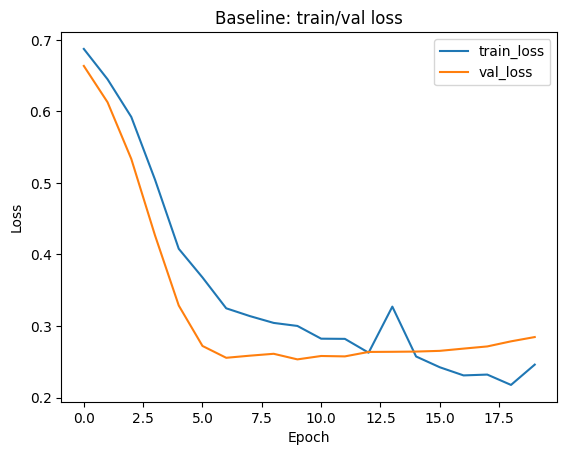

Val AUC final (baseline): 0.9413919413919414


In [12]:
import matplotlib.pyplot as plt

layers = [input_dim, 64, 32, 16, output_dim]
modeloGrande = build_sequential_model(layers)

hist_baseline = train_model_earlystop(modeloGrande, train_loader, val_loader, epochs=100, early_stopping=True, patience=10)

plt.figure()
plt.plot(hist_baseline['train_loss'], label='train_loss')
plt.plot(hist_baseline['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Baseline: train/val loss')
plt.show()
print('Val AUC final (baseline):', hist_baseline['val_auc'][-1])

Puedes observar que se ha detenido el entrenamiento de forma automática en la época 20, ya que el error cometido sobre el conjunto de validación se iba incrementando desde la época 10. Las épocas concretas pueden variar según la ejecución, ya que el modelo comienza con pesos aleatorios.

## 4. Reduciendo el tamaño de la red

La forma más sencilla de evitar el sobreajuste es reducir el tamaño del modelo, es decir, el número de parámetros ajustables por él (que viene  determinado por el número de capas y el número de unidades por capa). 

En Deep Learning, el número de parámetros ajustables en un modelo se denomina a menudo **capacidad del modelo**. Intuitivamente, un modelo con más parámetros tendrá más *capacidad de memorización* y, por tanto, podrá usar su aprendizaje para construir un diccionario que asocia perfectamente cada muestra de entrenamiento con su salida esperada. Obviamente, un aprendizaje basado en la memorización no tiene posibilidades de generalizar correctamente. 

Por ejemplo, un modelo con 500.000 parámetros binarios podría fácilmente aprender la clase de cada dígito en el problema MNIST: sólo necesitaríamos 10 parámetros binarios para cada uno de los 50.000 dígitos. Un modelo de este tipo sería inútil para clasificar nuevas muestras de dígitos si éstas presentan diferencias sustanciales, porque no ha extraido patrones que pueda usar en otros casos, sino solo ha memorizado las características propias de cada dato visto en el entrenamiento. 

Recordemos un hecho fundamental: los modelos de Deep Learning (debido al número de parámetros que tienen) suelen ser buenos para adaptarse a los datos de entrenamiento, pero el verdadero desafío del aprendizaje es la generalización, no el ajuste perfecto.

Sin embargo, si la red tiene recursos limitados para memorizar, no podrá construir ese diccionario de una forma satisfactoria (salvo que haya pocos datos de entrenamiento) y, en consecuencia, para minimizar la pérdida durante el entrenamiento tendrá que recurrir al aprendizaje de patrones (que no son más que representaciones comprimidas) que le permitan ajustarse al mayor número posible de datos vistos. Este es precisamente el tipo de representaciones que interesa. 

No podemos ser muy extremistas, al mismo tiempo que limitamos la capacidad de almacenamiento del modelo, ha de tenerse en cuenta que se deben utilizar modelos que tengan suficientes parámetros para que la complejidad de la estructura aprendida por el modelo no sea demasiado simple, es decir, hay que llegar a un equilibrio entre un "modelo memorizante" y un "modelo inútil".

Por desgracia, no existe una fórmula mágica para determinar cuál es el número correcto de capas, o cuál es el tamaño correcto para cada capa, por lo que habrá que evaluar una colección de arquitecturas diferentes para encontrar aquella que es más adecuada al problema que se quiere resolver y a los datos que tenemos de él. El flujo de trabajo general para encontrar un tamaño apropiado es comenzar con relativamente pocas capas y aumentar el tamaño de las mismas, o añadir nuevas capas, hasta que se obtenga un rendimiento decreciente en la pérdida en validación (no en entrenamiento, que, salvo casos extraños, siempre tenderá a mejorar).

Probemos esto en nuestro ejemplo de clasificación de enfermedades cardiacas. Vamos a definir tres redes, la anterior, una más pequeña y otra aún más pequeña:

In [13]:
from torchsummary import summary

modeloGrande = build_sequential_model([input_dim, 64, 32, 16, output_dim])

print("--- Arquitectura Detallada del Modelo Grande ---")
summary(modeloGrande,input_size=(1,input_dim),device='cpu')  


--- Arquitectura Detallada del Modelo Grande ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           1,536
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 16]             528
              ReLU-6                [-1, 1, 16]               0
            Linear-7                 [-1, 1, 1]              17
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [14]:
modeloMediano = build_sequential_model([input_dim, 16, 16, output_dim])

print("--- Arquitectura Detallada del Modelo Mediano ---")
summary(modeloMediano,input_size=(1,input_dim),device='cpu') 


--- Arquitectura Detallada del Modelo Mediano ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             384
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 16]             272
              ReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
Total params: 673
Trainable params: 673
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
modeloPequeno = build_sequential_model([input_dim, 4, 4, output_dim])

print("--- Arquitectura Detallada del Modelo Pequeño ---")
summary(modeloPequeno,input_size=(1,input_dim),device='cpu') 

--- Arquitectura Detallada del Modelo Pequeño ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              96
              ReLU-2                 [-1, 1, 4]               0
            Linear-3                 [-1, 1, 4]              20
              ReLU-4                 [-1, 1, 4]               0
            Linear-5                 [-1, 1, 1]               5
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Podemos observar, con la función summary, que el número de parámetros por capa, y en total, se ve drásticamente reducido. Hagamos el entrenamiento y mostremos las gráficas para ver cómo se comportan. Esta vez sin early stop, para ver hasta qué punto sobreajustan.

Entrenando modelo grande
Entrenando modelo mediano
Entrenando modelo pequeño


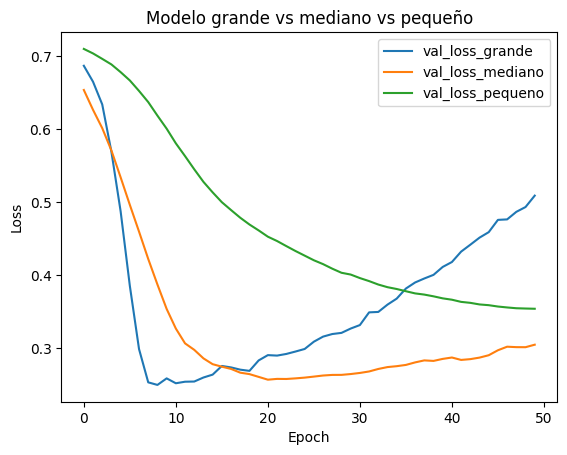

Val AUC final (grande): 0.9212454212454213
Val AUC final (mediano): 0.9487179487179487
Val AUC final (pequeño): 0.935897435897436


In [16]:
print('Entrenando modelo grande')
hist_grande  = train_model_earlystop(modeloGrande,  train_loader, val_loader, epochs=50, early_stopping=False, verbose = False)  
print('Entrenando modelo mediano')
hist_mediano = train_model_earlystop(modeloMediano, train_loader, val_loader, epochs=50, early_stopping=False, verbose = False)  
print('Entrenando modelo pequeño')
hist_pequeno = train_model_earlystop(modeloPequeno, train_loader, val_loader, epochs=50, early_stopping=False, verbose = False)  

plt.figure()
plt.plot(hist_grande['val_loss'], label='val_loss_grande')
plt.plot(hist_mediano['val_loss'], label='val_loss_mediano')
plt.plot(hist_pequeno['val_loss'], label='val_loss_pequeno')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Modelo grande vs mediano vs pequeño')
plt.show()
print('Val AUC final (grande):', hist_grande['val_auc'][-1])
print('Val AUC final (mediano):', hist_mediano['val_auc'][-1])
print('Val AUC final (pequeño):', hist_pequeno['val_auc'][-1])

Podemos observar varias cosas interesantes:
* El **modelo grande** **sobreajusta** mucho más que el resto de modelos, llegando a empeorar el error de pérdida hasta incluso a niveles del punto de inicio.
* El **modelo mediano** sobreajusta **levemente**, a partir de la época 18 aproximadamente.
* El **modelo pequeño** **no llega a sobreajustar, pero tampoco a ajustar** demasiado bien, ya que no llega a tener el nivel de rendimiento que la red mediana (su error es siempre superior, incluso más el modelo mediano sobreajustado).

Se puede observar que la red grande consigue muy rápido que su pérdida de entrenamiento sea prácticamente nula. Mostrando que, como habíamos dicho anteriormente, cuanto mayor es la capacidad de la red, más rápido modela los datos de entrenamiento a la perfección, pero también más susceptible es al sobreajuste.

En este caso, una **configuración mediana**, de dos capas con 16 neuronas cada una, ha dado el mejor resultado. Por supuesto, habría que aplicar early stop para quedarnos con la red en su mejor punto. Esto demuestra que una red demasiado grande tiende a dar peores resultados si no aplicamos técnicas de regularización.

## 5. Regularizando los pesos

Principio de _la navaja de Occam_: "si se dan dos explicaciones distintas para un mismo suceso, la explicación correcta más probable es la más simple, la que hace el menor número de suposiciones adicionales". 

Como método que aspira a ser estándar en el avance del conocimiento, este mismo principio también se aplica a los modelos aprendidos por las redes neuronales: si fijamos los datos de entrenamiento y una arquitectura de red, hay múltiples asignaciones de pesos (lo que se traduce en múltiples _modelos_) que podrían explicar los datos, y los modelos más sencillos tienen menos probabilidad de sobreajustar que los más complejos.

Un *modelo sencillo* en este contexto es un modelo en el que la distribución de valores de los parámetros que lo definen tiene menos entropía (o un modelo que tiene en total menos parámetros, como vimos en la sección anterior). Por lo tanto, una forma común de mitigar el sobreajuste es poner límites a la complejidad de la red forzando que sus pesos tomen un rango de valores pequeños, lo que hace que la distribución de estos valores sea más _regular_. 

A este procedimiento, en general, se le llama **regularización de los pesos**, y se consigue añadiendo a la función de pérdida de la red un _coste_ asociado a tener grandes pesos. 

Este coste adiconal suele venir dado de dos formas:

* **Regularización L1 (Lasso)**: el coste es proporcional al _valor absoluto de los pesos_ (matemáticamente, la *norma L1* de los pesos). Suele dar como resultado que muchos pesos tomen el valor 0 (modelo disperso), por lo que a veces se identifica con un procedimiento de compresión de la red.

$$Coste= Loss + \lambda \times \sum_i |w_i|$$

* **Regularización L2 (Ridge)**: el coste es proporcional al _cuadrado de los valores de los pesos_ (matemáticamente, la *norma L2* de los pesos). En el contexto de las redes neuronales, a esta norma también se le llama _weight decay_, ya que fuerza a que los pesos tiendan a 0.
$$Coste= Loss + \lambda \times \sum_i |w_i|^2$$

En ambos casos, $\lambda$ es el factor de regularización aplicado. Cuando se combinan ambos factores de regularización, se denomina *Elastic Net*.

En PyTorch, la regularización L1 se realiza manualmente, mientras que la regularización L2 se realiza con un argumento en el optimizador. Para demostrar cómo hacerlo, vamos a ampliar la función que hicimos para entrenar modelos con earlystopping. Verás los cambios marcados con la palabra NUEVO en comentarios.

In [17]:
def train_model(model, train_loader, val_loader, lr=1e-3, epochs=200, l1_lambda=0.0, l2_lambda=0.0, early_stopping=True, patience=10, verbose=True):
    loss_fn = nn.BCEWithLogitsLoss()                  # función de pérdida será Binarcy Cross Entropy con Logits
    # NUEVO: Para L2, simplemente indicamos al optimizador que queremos usar weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda) # Usaremos Adam
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}  # Vamos a registrar el historial para luego hacer una gráfica
    # Variables para early stopping:    
    best_val_loss = np.inf
    best_state = None
    epochs_no_improve = 0
    # Bucle de entrenamiento
    for epoch in range(1, epochs+1):
        model.train()
        loss_acum = 0 
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits.squeeze(), yb) 
            # NUEVO Calculamos la norma L1 de los parámetros de la siguiente forma:
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm # fórmula de coste con L1
            loss.backward()
            optimizer.step()
            loss_acum += loss.item()             # acumulamos el valor de error de pérdida, no el tensor que lo contiene        
        # Calcular la media para entrenamiento
        train_loss = loss_acum / len(train_loader)
        # Evaluar sobre validación
        val_loss, val_auc = evaluate(model, val_loader, loss_fn) # usa la función que hemos hecho para evaluar el modelo                
        # Registrar resultados
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        if verbose:
            print(f"Epoch {epoch:03d} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_auc: {val_auc:.4f}")
        # Early stopping basado en val_loss
        if early_stopping:
            if val_loss < best_val_loss - 1e-6:   # cada vez que mejore, con un rango de error
                best_val_loss = val_loss   # el valor actual es mejor que el mejor hasta el momento
                best_state = copy.deepcopy(model.state_dict()) # guardar el modelo
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1     # una época más que no mejoramos
            # Si paciencia superada
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping: no mejora en val_loss durante {patience} épocas (best_val_loss={best_val_loss:.4f})")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return history  # El modelo ya se ha modificado, no hace falta devolverlo. Devolvemos el historial para hacer la gráfica

Ahora entrenaremos el modelo grande para ver cómo le afecta los regularizadores: sin regularizar, solo L1, solo L2, y ElasticNet (L1 y L2). 

In [18]:
model_noReg = build_sequential_model([input_dim, 64, 32, 16, output_dim])
hist_noReg = train_model_earlystop(model_noReg, train_loader, val_loader, epochs=100, early_stopping=True)
print('Val AUC final (No Regularization):', hist_noReg['val_auc'][-1])

Epoch 001 — train_loss: 0.6900, val_loss: 0.6706, val_auc: 0.9414
Epoch 002 — train_loss: 0.6483, val_loss: 0.6037, val_auc: 0.9560
Epoch 003 — train_loss: 0.5785, val_loss: 0.4953, val_auc: 0.9579
Epoch 004 — train_loss: 0.4957, val_loss: 0.3884, val_auc: 0.9560
Epoch 005 — train_loss: 0.3799, val_loss: 0.3263, val_auc: 0.9597
Epoch 006 — train_loss: 0.3468, val_loss: 0.2948, val_auc: 0.9542
Epoch 007 — train_loss: 0.3362, val_loss: 0.2938, val_auc: 0.9542
Epoch 008 — train_loss: 0.3067, val_loss: 0.2911, val_auc: 0.9524
Epoch 009 — train_loss: 0.3085, val_loss: 0.2834, val_auc: 0.9505
Epoch 010 — train_loss: 0.2873, val_loss: 0.2805, val_auc: 0.9505
Epoch 011 — train_loss: 0.2787, val_loss: 0.2859, val_auc: 0.9487
Epoch 012 — train_loss: 0.2777, val_loss: 0.2822, val_auc: 0.9524
Epoch 013 — train_loss: 0.3049, val_loss: 0.2846, val_auc: 0.9505
Epoch 014 — train_loss: 0.2545, val_loss: 0.2747, val_auc: 0.9542
Epoch 015 — train_loss: 0.2503, val_loss: 0.2812, val_auc: 0.9634
Epoch 016 

In [19]:
model_l1 = build_sequential_model([input_dim, 64, 32, 16, output_dim])
hist_l1 = train_model(model_l1, train_loader, val_loader, l1_lambda=1e-3, l2_lambda=0.0, epochs=100, early_stopping=True)
print('Val AUC final (L1):', hist_l1['val_auc'][-1])

Epoch 001 — train_loss: 1.0061, val_loss: 0.6586, val_auc: 0.9029
Epoch 002 — train_loss: 0.9486, val_loss: 0.6211, val_auc: 0.9341
Epoch 003 — train_loss: 0.8775, val_loss: 0.5652, val_auc: 0.9469
Epoch 004 — train_loss: 0.8107, val_loss: 0.4878, val_auc: 0.9487
Epoch 005 — train_loss: 0.7298, val_loss: 0.4179, val_auc: 0.9542
Epoch 006 — train_loss: 0.6671, val_loss: 0.3571, val_auc: 0.9597
Epoch 007 — train_loss: 0.5999, val_loss: 0.3104, val_auc: 0.9615
Epoch 008 — train_loss: 0.5781, val_loss: 0.2787, val_auc: 0.9597
Epoch 009 — train_loss: 0.5445, val_loss: 0.2799, val_auc: 0.9652
Epoch 010 — train_loss: 0.5176, val_loss: 0.2673, val_auc: 0.9670
Epoch 011 — train_loss: 0.5374, val_loss: 0.2664, val_auc: 0.9652
Epoch 012 — train_loss: 0.5054, val_loss: 0.2714, val_auc: 0.9615
Epoch 013 — train_loss: 0.5220, val_loss: 0.2664, val_auc: 0.9634
Epoch 014 — train_loss: 0.4750, val_loss: 0.2658, val_auc: 0.9634
Epoch 015 — train_loss: 0.4949, val_loss: 0.2669, val_auc: 0.9615
Epoch 016 

In [20]:
model_l2 = build_sequential_model([input_dim, 64, 32, 16, output_dim])
hist_l2 = train_model(model_l2, train_loader, val_loader, l1_lambda=0.0, l2_lambda=1e-3, epochs=100, early_stopping=True)
print('Val AUC final (L2):', hist_l2['val_auc'][-1])

Epoch 001 — train_loss: 0.6972, val_loss: 0.6826, val_auc: 0.8938
Epoch 002 — train_loss: 0.6645, val_loss: 0.6361, val_auc: 0.9341
Epoch 003 — train_loss: 0.6041, val_loss: 0.5588, val_auc: 0.9524
Epoch 004 — train_loss: 0.5279, val_loss: 0.4510, val_auc: 0.9542
Epoch 005 — train_loss: 0.4311, val_loss: 0.3713, val_auc: 0.9579
Epoch 006 — train_loss: 0.3771, val_loss: 0.3188, val_auc: 0.9615
Epoch 007 — train_loss: 0.3326, val_loss: 0.2892, val_auc: 0.9597
Epoch 008 — train_loss: 0.3139, val_loss: 0.2690, val_auc: 0.9615
Epoch 009 — train_loss: 0.3121, val_loss: 0.2647, val_auc: 0.9597
Epoch 010 — train_loss: 0.3200, val_loss: 0.2653, val_auc: 0.9670
Epoch 011 — train_loss: 0.2744, val_loss: 0.2565, val_auc: 0.9707
Epoch 012 — train_loss: 0.2720, val_loss: 0.2551, val_auc: 0.9689
Epoch 013 — train_loss: 0.3338, val_loss: 0.2577, val_auc: 0.9744
Epoch 014 — train_loss: 0.2486, val_loss: 0.2643, val_auc: 0.9634
Epoch 015 — train_loss: 0.2634, val_loss: 0.2635, val_auc: 0.9652
Epoch 016 

In [21]:
model_elasticnet = build_sequential_model([input_dim, 64, 32, 16, output_dim])
hist_elastic = train_model(model_elasticnet, train_loader, val_loader, l1_lambda=1e-3, l2_lambda=1e-3, epochs=100, early_stopping=True)
print('Val AUC final (ElasticNet):', hist_elastic['val_auc'][-1])

Epoch 001 — train_loss: 1.0237, val_loss: 0.6935, val_auc: 0.8681
Epoch 002 — train_loss: 0.9638, val_loss: 0.6714, val_auc: 0.9377
Epoch 003 — train_loss: 0.9106, val_loss: 0.6362, val_auc: 0.9542
Epoch 004 — train_loss: 0.8487, val_loss: 0.5752, val_auc: 0.9652
Epoch 005 — train_loss: 0.7804, val_loss: 0.4929, val_auc: 0.9725
Epoch 006 — train_loss: 0.6846, val_loss: 0.4058, val_auc: 0.9725
Epoch 007 — train_loss: 0.6348, val_loss: 0.3300, val_auc: 0.9707
Epoch 008 — train_loss: 0.6130, val_loss: 0.2978, val_auc: 0.9707
Epoch 009 — train_loss: 0.5341, val_loss: 0.2875, val_auc: 0.9689
Epoch 010 — train_loss: 0.5021, val_loss: 0.2678, val_auc: 0.9725
Epoch 011 — train_loss: 0.4839, val_loss: 0.2540, val_auc: 0.9744
Epoch 012 — train_loss: 0.4699, val_loss: 0.2481, val_auc: 0.9762
Epoch 013 — train_loss: 0.4588, val_loss: 0.2459, val_auc: 0.9780
Epoch 014 — train_loss: 0.4506, val_loss: 0.2461, val_auc: 0.9762
Epoch 015 — train_loss: 0.4456, val_loss: 0.2451, val_auc: 0.9744
Epoch 016 

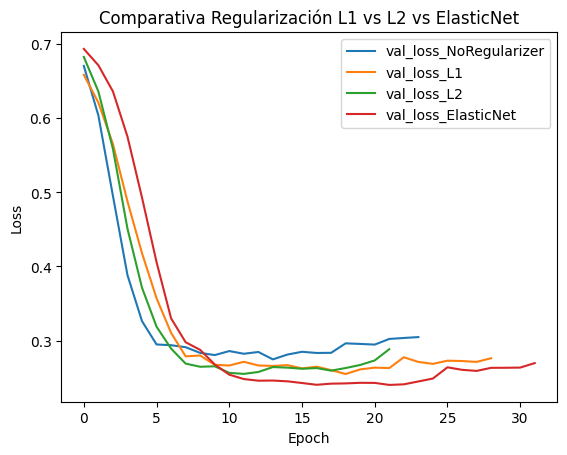

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(hist_noReg['val_loss'], label='val_loss_NoRegularizer')
plt.plot(hist_l1['val_loss'], label='val_loss_L1')
plt.plot(hist_l2['val_loss'], label='val_loss_L2')
plt.plot(hist_elastic['val_loss'], label='val_loss_ElasticNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparativa Regularización L1 vs L2 vs ElasticNet')
plt.show()

Como se puede observar, usar regularización permite que el modelo sea más resistente al sobreajuste original, incluso manteniendo el mismo número de parámetros. En este caso, L1 funciona mejor, ya que comprime el modelo. Además, L2 también ayuda puesto que la versión combinada (ElasticNet) permite llegar aún más allá.

## 6. Dropout

**Dropout** es una de las técnicas de regularización más efectivas y más comúnmente utilizadas para las redes neuronales, desarrollada por Hinton y su equipo de estudiantes de la Universidad de Toronto en 2014 (http://jmlr.org/papers/v15/srivastava14a.html). 

El Dropout, aplicado a una capa, consiste en la _eliminación aleatoria_ (lo que se traduce en poner a 0) de un número de características de salida de la capa durante el entrenamiento:

Supongamos que una capa devolviese un vector `[0.2, 0.5, 1.3, 0.8, 1.1]` para una de las muestras de entrada durante el entrenamiento. Tras la aplicación del Dropout, este vector tendrá unas cuantas entradas nulas distribuidas al azar, por ejemplo, `[0, 0.5, 1.3, 0, 1.1]`. 

![](https://github.com/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/imgs/dropout.gif?raw=1)

Esto significa que sus contribuciones a la activación de las neuronas se eliminan temporalmente en la etapa _forward_, así como la actualización de cualquiera de sus pesos en la etapa _backward_. Cuando la activación de una neurona se anula, el efecto que pudiera tener en conjunción con otras neuronas con las que está conectada se pierde, por lo que estas otras neuronas han de aprender la misma representación sin considerar su trabajo conjunto, lo que lleva a disponer de representaciones internas más robustas e independientes.

La _tasa de dropout_ es la fracción de características que se ponen a 0, y normalmente se ajusta entre 0,2 y 0,5. Y se debe tener en cuenta que, al igual que todas las técnicas de regularización, durante la fase de test no se hace dropout, sino únicamente durante la fase de entrenamiento, que es cuando queremos limitar la capacidad del modelo. Esto conlleva que los valores de salida de la capa durante el test han de reducirse en un factor igual al dropout, con el fin de equilibrar el hecho de que hay más unidades activas que durante el entrenamiento (si no, sería imposible que el modelo respondiese en tiempo de test lo que ha aprendido en el entrenamiento).

Es decir, si durante el entrenamiento el resultado es:

In [21]:
# Durante el entrenamiento hemos descartado el 50% de las unidades de salida
# layer_output *= np.randint(0, high=2, size=layer_output.shape)


Entonces en el test hemos de ajustar:

In [22]:
# En test:
# layer_output *= 0.5

Como sería incómodo tener que estar considerando este hecho durante el tiempo de test, este proceso se puede implementar haciendo ambas operaciones durante el tiempo de entrenamiento, de forma que no es necesario considerarlo a la hora de hacer test: 

In [23]:
# Durante el entrenamiento:
# layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Y a continuación escalamos para compensar el efecto del dropout
# layer_output /= 0.5


Pero, ¿porqué esta técnica reduce el sobreajuste? La idea central es que la introducción de ruido en los valores de salida de una capa puede romper patrones que no son significativos y que la red empezaría a memorizar si no hubiera ruido presente. 

Para no tener que hacerlo a mano, PyTorch proporciona este regularizador por medio de capas `Dropout` que se aplican a las salidas de la capa anterior (es decir, que más que un proceso de regularización que se hace dentro de la capa, se convierte en una capa adicional que se encarga de realizar esta técnica tras ella):

In [ ]:
# nn.Dropout(0.5)

Vamos a introducir dos capas `Dropout` en el modelo anterior para ver si reducen el sobreajuste. Primero podemos modificar la función que genera modelos secuenciales, permitiendo introducir factores de dropout:

In [23]:
def build_sequential_model_dropout(layer_sizes,dropout=[]): 
    # Lista para almacenar las capas que se añadirán al modelo (llamamos a nn.Sequential al final)
    layers = []
    
    # El tamaño de la lista debe ser al menos 2 (entrada y salida)
    if len(layer_sizes) < 2:
        raise ValueError("La lista de tamaños de capa debe contener al menos dos elementos (entrada y salida).")

    # Iterar sobre los tamaños de capa para crear las capas Lineales y ReLU, hasta la penúltima
    for i in range(len(layer_sizes) - 1):
        input_size = layer_sizes[i]
        output_size = layer_sizes[i+1]
        
        # 1. Añadir la capa lineal (nn.Linear)
        layers.append(nn.Linear(in_features=input_size, out_features=output_size))
       
        # 2. Añadir la activación ReLU, excepto en la última capa de salida        
        if i < len(layer_sizes) - 2:
            layers.append(nn.ReLU())

        # 2. Si hay factores de dropout definidos, añadimos una capa con el correspondiente factor
        #    excepto en la última capa
        if dropout and i < len(layer_sizes) - 2:
            layers.append(nn.Dropout(dropout[i]))
            
    # Crear y devolver el modelo nn.Sequential con las capas definidas
    model = nn.Sequential(*layers)
    
    return model

Modelo con Dropout Generado:
Sequential(
  (0): Linear(in_features=23, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=16, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           1,536
              ReLU-2                [-1, 1, 64]               0
           Dropout-3                [-1, 1, 64]               0
            Linear-4                [-1, 1, 32]           2,080
              ReLU-5                [-1, 1, 32]               0
           Dropout-6                [-1, 1, 32]               0
            Linear-7                [-1, 1, 16]             

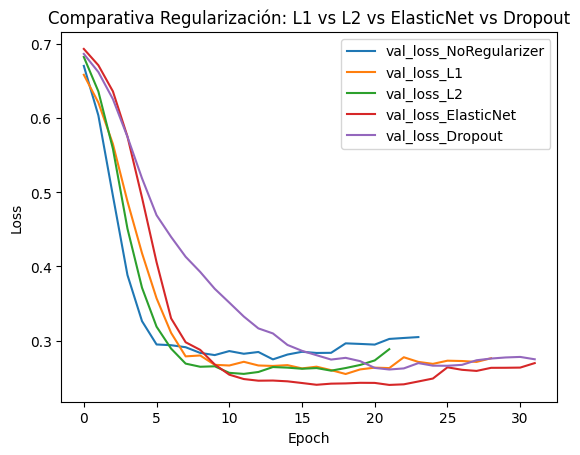

In [24]:
# Definición de la red
layers = [input_dim, 64, 32, 16, output_dim] # repetimos con el modelo grande
dropouts = [0.5,0.5,0.3]   # añadimos dos capas de dropout a 0.5
model_drop = build_sequential_model_dropout(layers,dropouts)

print("Modelo con Dropout Generado:")
print(model_drop)
summary(model_drop,input_size=(1,input_dim),device='cpu') 

# Entrenamiento
# para comparar, no aplicamos L1 ni L2, solo el modelo con dropout
hist_dropout = train_model_earlystop(model_drop, train_loader, val_loader, epochs=100, early_stopping=True)
print('Val AUC final (Dropout):', hist_dropout['val_auc'][-1])

# Visualización
plt.figure()
plt.plot(hist_noReg['val_loss'], label='val_loss_NoRegularizer')
plt.plot(hist_l1['val_loss'], label='val_loss_L1')
plt.plot(hist_l2['val_loss'], label='val_loss_L2')
plt.plot(hist_elastic['val_loss'], label='val_loss_ElasticNet')
plt.plot(hist_dropout['val_loss'], label='val_loss_Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparativa Regularización: L1 vs L2 vs ElasticNet vs Dropout')
plt.show()


Podemos ver cómo de efectiva es la técnica de Dropout. Consigue mantener el sobreajuste durante más tiempo que con L1 y L2, obteniendo al final un resultado similar.

### Algunos trucos para usar Dropout

El trabajo original sobre Dropout proporciona algunos resultados experimentales sobre algunos problemas estándar de Machine Learning. Como resultado de estos experimentos, se ofrecen algunas heurísticas que pueden ser útiles a la hora de usar esta técnica en la práctica:

* Por norma general, usa un valor de dropout bajo, entre 0,2 y 0,5. Un valor de 0,2 puede ser un buen punto de partida. Un valor demasiado bajo apenas tiene efecto, y demasiado alto lleva a un aprendizaje muy pobre.
* Usa una red más grande. Se tienen mejores resultados cuando se usa sobre redes grandes, algo que da al modelo la posibilidad de aprender representaciones independientes.
* Puedes usar dropout tanto en la capa visible (la de entrada) como en las capas ocultas. La aplicación de dropout en cada una de las capas de la red ha dado buenos resultados.
* Permite usar una tasa de aprendizaje grande con cadencia (_decay_) y un momento grande, por ejemplo, multiplica la tasa por un factor entre 10 y 100 y usa valores de momento de 0,9 a 0,99.
* Restringe el tamaño de los pesos de la red. Una tasa de aprendizaje alta puede dar lugar a redes con pesos muy altos, así que aplicar una regularización L1 adicional (con tamaños acotados por 4 o 5) puede mejorar mucho los resultados.

## 7. Conclusiones

En resumen, las formas más comunes de prevenir el sobreajuste en redes neuronales son:

* Conseguir más (y más variados) datos de entrenamiento. Si el problema lo permite, quizás se pueda usar alguna técnica artificial de _Data Augmentation_.
* Parar el entrenamiento cuando se observa que comienza el sobreajuste.
* Reducir la capacidad de la red (número de parámetros).
* Añadir regularización a los pesos (penalizando configuraciones con pesos muy grandes o más irregulares).
* Añadir dropout (añadir ruido con ceros).

8. Ejercicios propuestos

* Crea una función que reciba una configuración de capas (una lista `layers` como la que solemos utilizar) y entrene modelos con dicha arquitectura de la siguiente forma:
   * entrenar un modelo con parada temprana
   * entrenar un modelo ElasticNet y parada temprana
   * entrenar un modelo con Dropout y parada temprana. Para dropout, puedes usar siempre el factor 0.5. Recuerda introducir una capa de dropout por cada capa menos la de salida.
   * entrenar un modelo con ElasticNet, Dropout y parada temprana
   * mostrar una gráfica comparativa de cómo decae el error en validación en los cuatro casos
   * mostrar una gráfica con el mejor AUC conseguido en cada caso
   * Consejo: las funciones que hacen cada caso ya están definidas arriba, simplemente combina todo en una función.
* Juega con la función anterior con arquitecturas más grandes y otras más pequeñas, para ver qué combinación funciona mejor, y cómo afecta cada técnica de regularización.
* Volviendo al ejemplo de dropout, prueba de nuevo a entrenar un modelo subiendo el factor de aprendizaje, ¿hasta qué punto podemos aumentarlo?